<a href="https://colab.research.google.com/github/hmobley/liveproject_water/blob/master/solutions/milestone5/5_Model_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="font-size: 1em; padding: 0; margin: 0;">

<tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #182AEB; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #ffffff;">Deep Learning </span> for Satellite Image Classification</span> (Manning Publications)<br/>by <em>Daniel Buscombe</em></strong><br/><br/>
        <strong>> Chapter 5: Deliverable Solution </strong><br/>
    </p>   

#### Preliminaries for Colab

Like Part 3 and 4, below are some convenience functions for those working on Google Colab with a GPU runtime

In [1]:
# must be a pre-written method for this!
def clear_drive():
  !rm -r nwpu_images
  !rm -r nwpu_label_images
  !rm -r s2cloudless_imagery
  !rm -r s2cloudless_label_imagery
  !rm nwpu_images.zip
  !rm nwpu_label_images.zip
  !rm opt_model_1_early
  !rm opt_model_1_early_hist
  !rm opt_model_2_big
  !rm opt_model_2_big_hist
  !rm opt_model_3_bn
  !rm opt_model_3_bn_hist
  !rm opt_model_4_res
  !rm opt_model_4_res_hist
  !rm opt_model_5_res_dice
  !rm opt_model_5_res_dice_hist
  !rm opt_model_6_res_dice2
  !rm opt_model_6_res_dice2_hist
  !rm s2cloudless_imagery.zip
  !rm s2cloudless_label_imagery.zip
  !rm res_unet8.h5
  !rm res_dice_unet2.h5
  !rm -r weights

In [2]:
clear_drive()

rm: cannot remove 'nwpu_images': No such file or directory
rm: cannot remove 'nwpu_label_images': No such file or directory
rm: cannot remove 's2cloudless_imagery': No such file or directory
rm: cannot remove 's2cloudless_label_imagery': No such file or directory
rm: cannot remove 'nwpu_images.zip': No such file or directory
rm: cannot remove 'nwpu_label_images.zip': No such file or directory
rm: cannot remove 'opt_model_1_early': No such file or directory
rm: cannot remove 'opt_model_1_early_hist': No such file or directory
rm: cannot remove 'opt_model_2_big': No such file or directory
rm: cannot remove 'opt_model_2_big_hist': No such file or directory
rm: cannot remove 'opt_model_3_bn': No such file or directory
rm: cannot remove 'opt_model_3_bn_hist': No such file or directory
rm: cannot remove 'opt_model_4_res': No such file or directory
rm: cannot remove 'opt_model_4_res_hist': No such file or directory
rm: cannot remove 'opt_model_5_res_dice': No such file or directory
rm: cannot

In [ ]:
load_res_dice_mix_history = 1
if load_res_dice_mix_history:
  import pickle

In [3]:
#colab = 0
colab = 1

if colab==1:
    %tensorflow_version 2.x
    !pip install --default-timeout=1000 tensorflow-gpu==2.0   

     |████████████████████████████████| 380.8MB 41kB/s 
     |████████████████████████████████| 450kB 44.3MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 3.8MB 40.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=3931a376a3a1fd7a5de81110a0db8bc5bd899f403f6a571ee0749aa1eb33dc18
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

In [4]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
True


Convenience functions if you need to download example (minimal) imagery sets derived from NWPU and Sentinel-2 cloudless:

In [5]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


#s2 cloudless imagery
file_id = '1iMfIjr_ul49Ghs2ewazjCt8HMPfhY47h'
destination = 's2cloudless_imagery.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

#s2 cloudless labels
file_id = '1c7MpwKVejoUuW9F2UaF_vps8Vq2RZRfR'
destination = 's2cloudless_label_imagery.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

#nwpu imagery
file_id = '1gtuqy1VlU8-M5IEMnmiSuTlI5PxQPnGB'
destination = 'nwpu_images.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

#nwpu labels
file_id = '1W5LGbcYAcFbG5YjLgX_ekBn0u5Rno35x'
destination = 'nwpu_label_images.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)                        

In [6]:
import zipfile
def unzip(f):
    """
    f = file to be unzipped
    """    
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall()
        
if colab==1:
    unzip('s2cloudless_imagery.zip')
    unzip('s2cloudless_label_imagery.zip')   
    unzip('nwpu_images.zip')
    unzip('nwpu_label_images.zip')       

#### Install libraries

Uncomment below to install the module and its dependencies:

In [7]:
#!pip install cython
#!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

Import the libraries we will need:

In [9]:
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-uwc3evw5
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-uwc3evw5
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp36-cp36m-linux_x86_64.whl size=2226019 sha256=5ae5a05af7b6e9ebe6b1e5fe1e1fe5509e79f664d1676bd4934f6c46e3defb20
  Stored in directory: /tmp/pip-ephem-wheel-cache-r8im2ntj/wheels/81/ac/ed/09f1890b954ca1ff7f189518cc9a319138e50e7ea88937fae9
Successfully built pydensecrf


In [10]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, Conv2DTranspose, Flatten, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from pydensecrf import densecrf
from pydensecrf.utils import unary_from_labels
import numpy as np

#### Define U-Resnet and CRF models

In [11]:
def batchnorm_act(x):
    x = BatchNormalization()(x)
    return Activation("relu")(x)

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batchnorm_act(x)
    return Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)

def bottleneck_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([conv, bottleneck])

def res_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([bottleneck, res])

def upsamp_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    return Concatenate()([u, xskip])

def res_unet(sz, f):
    inputs = Input(sz)
    
    ## downsample  
    e1 = bottleneck_block(inputs, f); f = int(f*2)
    e2 = res_block(e1, f, strides=2); f = int(f*2)
    e3 = res_block(e2, f, strides=2); f = int(f*2)
    e4 = res_block(e3, f, strides=2); f = int(f*2)
    _ = res_block(e4, f, strides=2)
    
    ## bottleneck
    b0 = conv_block(_, f, strides=1)
    _ = conv_block(b0, f, strides=1)
    
    ## upsample
    _ = upsamp_concat_block(_, e4)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e3)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e2)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e1)
    _ = res_block(_, f)
    
    ## classify
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(_)
    
    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [12]:
def crf_labelrefine(input_image, predicted_labels):
    
    compat_spat=10
    compat_col=30
    theta_spat = 20
    theta_col = 80
    num_iter = 7
    num_classes = 2
    
    h, w = input_image.shape[:2] #get image dimensions
    
    d = densecrf.DenseCRF2D(w, h, 2) #create a CRF object

    # For the predictions, densecrf needs 'unary potentials' which are labels (water or no water)
    predicted_unary = unary_from_labels(predicted_labels.astype('int')+1, num_classes, gt_prob= 0.51)
    
    # set the unary potentials to CRF object
    d.setUnaryEnergy(predicted_unary)

    # to add the color-independent term, where features are the locations only:
    d.addPairwiseGaussian(sxy=(theta_spat, theta_spat), compat=compat_spat, kernel=densecrf.DIAG_KERNEL,
                          normalization=densecrf.NORMALIZE_SYMMETRIC)

    input_image_uint = (input_image * 255).astype(np.uint8) #enfore unsigned 8-bit
    # to add the color-dependent term, i.e. 5-dimensional features are (x,y,r,g,b) based on the input image:    
    d.addPairwiseBilateral(sxy=(theta_col, theta_col), srgb=(5, 5, 5), rgbim=input_image_uint,
                           compat=compat_col, kernel=densecrf.DIAG_KERNEL, 
                           normalization=densecrf.NORMALIZE_SYMMETRIC)

    # Finally, we run inference to obtain the refined predictions:
    refined_predictions = np.array(d.inference(num_iter)).reshape(num_classes, h, w)
    
    # since refined_predictions will be a 2 x width x height array, 
    # each slice respresenting probability of each class (water and no water)
    # therefore we return the argmax over the zeroth dimension to return a mask
    return np.argmax(refined_predictions,axis=0)

#### Define Training functions (generators and callbacks)

In [13]:
def image_batch_generator(files, batch_size = 32, sz = (512, 512)):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images 
        rawfile = f'nwpu_images/data/{f}'
        raw = Image.open(rawfile)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]
            
        #get the image dimensions, find the min dimension, then square the image off    
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:] 
            
        batch_x.append(raw)
        
        #get the masks. 
        maskfile = rawfile.replace('nwpu_images','nwpu_label_images')+'_mask.jpg'
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        mask = np.max(np.array(mask.resize(sz)),axis=2)
        # water pixels are always greater than 100
        mask = (mask>200).astype('int')
        
        mask = mask[:n,:n]
        
        # use CRF to refine mask before it is used as a label
        mask = crf_labelrefine(raw, mask).squeeze()

        batch_y.append(mask)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

In [14]:
# inheritance for training process plot 
class PlotLearning(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'dice_coef=',logs.get('dice_coef'),'val_dice_coef=',logs.get('val_dice_coef'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        infile = f's2cloudless_imagery/data/{path}'
        raw = Image.open(infile)
        raw = np.array(raw.resize((512, 512)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = 255*model.predict(np.expand_dims(raw, 0)).squeeze()
        print(np.max(pred))
                
        #mask post-processing 
        msk  = (pred>60).astype('int') #100    
        
        # use CRF to refine mask before it is used as a label
        msk = crf_labelrefine(raw, msk).squeeze()
      
        msk = np.stack((msk,)*3, axis=-1)
          
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()      

In [15]:
def build_callbacks(filepath, min_delta, min_lr, factor):

    earlystop = EarlyStopping(monitor="val_loss", 
                                  mode="min", patience=5) 
    
    # reduction of learning rate if and when validation scores plateau upon successive epochs
    reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=5, 
                                    verbose=1, mode='auto', min_delta=min_delta, 
                                    cooldown=5, min_lr=min_lr)

    # set checkpoint file 
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                   verbose=0, save_best_only=True, mode='min', 
                                   save_weights_only = True)
        
    callbacks = [model_checkpoint, reduceloss_plat, earlystop, PlotLearning()]

    return callbacks  

#### Define the loss function and compile the ResidualUNet model

In [16]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [17]:
model = res_unet((512, 512, 3), 32)
model.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef])

#### Define training hyper-parameters, test/train files and such

In [18]:
#split into training and testing
train_files = os.listdir('nwpu_images/data')
test_files  = os.listdir('s2cloudless_imagery/data')

# a tolerance for the training. 
min_delta = 0.0001

# minimum learning rate (lambda)
min_lr = 0.0001

# the factor applied to the learning rate when the appropriate triggers are made
factor = 0.8

batch_size = 2

filepath = 'res_dice_crf_unet'+str(batch_size)+'.h5'

#### Create file generators and run model training

#### Test NWPU model on S2 imagery

First, set up a new generator function to generate batches of S2 augmented imagery and associated labels. Then, define a function that will use the model (trained on NWPU imagery) to estimate the binary semantic segmentation mask for 100 images. Finally, we'll look at the mean IOU score, and their distribution

In [19]:
def image_batch_generatorS2(files, batch_size = 32, sz = (512, 512)):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images 
        rawfile = f's2cloudless_imagery/data/{f}'
        raw = Image.open(rawfile)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]
            
        #get the image dimensions, find the min dimension, then square the image off    
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:] 
            
        batch_x.append(raw)
        
        #get the masks. 
        maskfile = rawfile.replace('s2cloudless_imagery','s2cloudless_label_imagery')+'_mask.jpg'
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        mask = np.max(np.array(mask.resize(sz)),axis=2)
        # water pixels are always greater than 100
        mask = (mask>100).astype('int')

        # use CRF to refine mask before it is used as a label
        mask = crf_labelrefine(raw, mask).squeeze()
    
        mask = mask[:n,:n]

        batch_y.append(mask)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

In [20]:
train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator  = image_batch_generatorS2(test_files, batch_size = batch_size)
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print(train_steps)
print(test_steps)

285
20


i= 1 loss= 0.2597762038833217 val_loss= 0.902520763874054 dice_coef= 0.740224 val_dice_coef= 0.09747924
254.99059


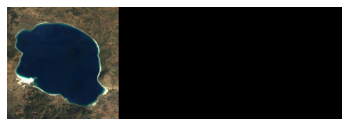

i= 2 loss= 0.2699169809358162 val_loss= 0.2332265704870224 dice_coef= 0.730083 val_dice_coef= 0.76677346
255.0


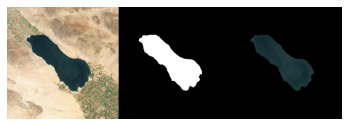

i= 3 loss= 0.22909223677819235 val_loss= 0.2358178973197937 dice_coef= 0.7709077 val_dice_coef= 0.76418215
255.0


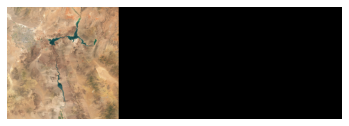

i= 4 loss= 0.22486362101738913 val_loss= 0.30097392201423645 dice_coef= 0.7751365 val_dice_coef= 0.6990261
255.0


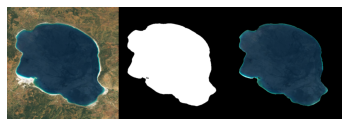

i= 5 loss= 0.22524727122825489 val_loss= 0.15976132154464723 dice_coef= 0.7747529 val_dice_coef= 0.8402387
255.0


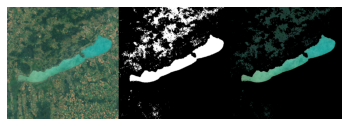

i= 6 loss= 0.20905728089182 val_loss= 0.38047281801700594 dice_coef= 0.7909429 val_dice_coef= 0.6195272
255.0


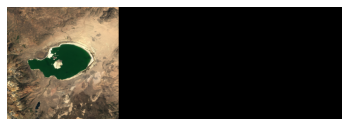

i= 7 loss= 0.2013840204791019 val_loss= 0.20232269465923308 dice_coef= 0.7986161 val_dice_coef= 0.79767734
255.0


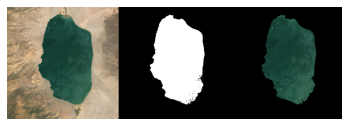

i= 8 loss= 0.18433827412755865 val_loss= 0.5962930560112 dice_coef= 0.8156618 val_dice_coef= 0.40370694
255.0


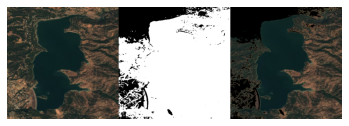

i= 9 loss= 0.19863273051747105 val_loss= 0.15153504610061647 dice_coef= 0.801367 val_dice_coef= 0.84846497
0.0


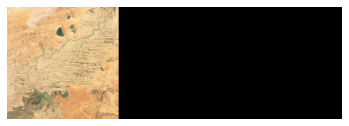

i= 10 loss= 0.1640360771564015 val_loss= 0.21986480355262755 dice_coef= 0.83596396 val_dice_coef= 0.7801353
255.0


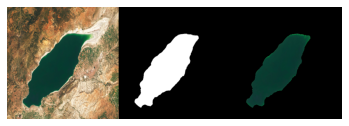

i= 11 loss= 0.15984426841401217 val_loss= 0.14209124147892 dice_coef= 0.84015566 val_dice_coef= 0.8579087
255.0


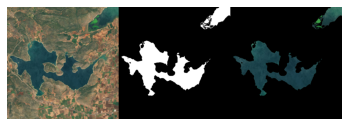

i= 12 loss= 0.1392190650889748 val_loss= 0.1916574627161026 dice_coef= 0.86078066 val_dice_coef= 0.80834246
255.0


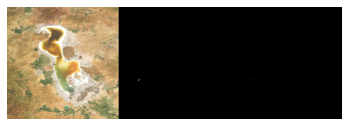

i= 13 loss= 0.1529857129381414 val_loss= 0.20749050080776216 dice_coef= 0.8470144 val_dice_coef= 0.7925095
255.0


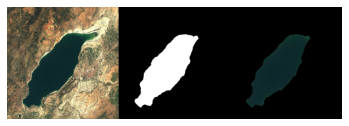

i= 14 loss= 0.13290367691140426 val_loss= 0.22268673479557038 dice_coef= 0.8670961 val_dice_coef= 0.77731323
255.0


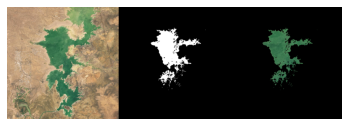

i= 15 loss= 0.13920739324469317 val_loss= 0.2502113193273544 dice_coef= 0.8607925 val_dice_coef= 0.74978864
255.0


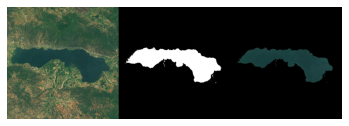


Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
i= 16 loss= 0.15617371211972153 val_loss= 0.26449852585792544 dice_coef= 0.84382653 val_dice_coef= 0.73550147
255.0


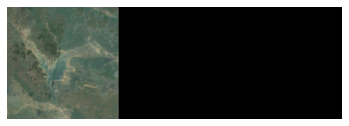

i= 17 loss= 0.1301344823419002 val_loss= 0.2174203485250473 dice_coef= 0.8698655 val_dice_coef= 0.7825796
255.0


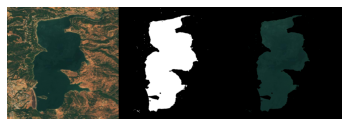

i= 18 loss= 0.11876233251471269 val_loss= 0.21064691245555878 dice_coef= 0.88123757 val_dice_coef= 0.789353
255.0


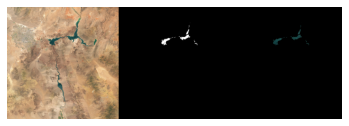

i= 19 loss= 0.10667274667505633 val_loss= 0.17108569145202637 dice_coef= 0.89332736 val_dice_coef= 0.82891434
255.0


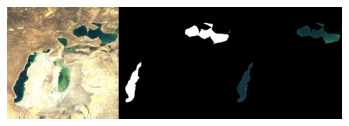

i= 20 loss= 0.12422831079416108 val_loss= 0.22117282152175904 dice_coef= 0.8757718 val_dice_coef= 0.77882713
255.0


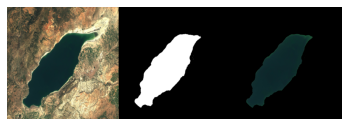

i= 21 loss= 0.11817517991651569 val_loss= 0.1675688683986664 dice_coef= 0.88182473 val_dice_coef= 0.8324312
255.0


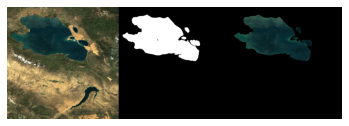

i= 22 loss= 0.09946810258062262 val_loss= 0.26547602713108065 dice_coef= 0.90053195 val_dice_coef= 0.73452395
0.0


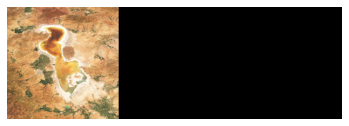

i= 23 loss= 0.10317424284784417 val_loss= 0.2004821240901947 dice_coef= 0.8968257 val_dice_coef= 0.7995178
0.0


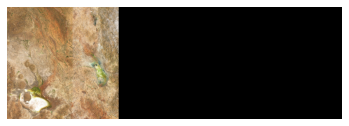

i= 24 loss= 0.11119054555892945 val_loss= 0.19994318783283233 dice_coef= 0.8888094 val_dice_coef= 0.8000568
255.0


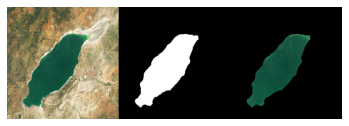


Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
i= 25 loss= 0.10266771881203902 val_loss= 0.1706518530845642 dice_coef= 0.89733243 val_dice_coef= 0.8293481
255.0


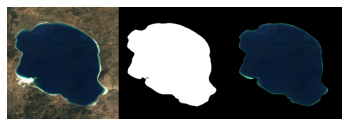

i= 26 loss= 0.09405249357223511 val_loss= 0.19363982677459718 dice_coef= 0.90594727 val_dice_coef= 0.8063601
0.0


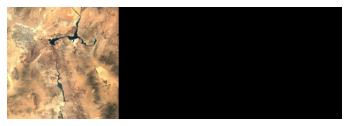

i= 27 loss= 0.10685840134035077 val_loss= 0.1775517702102661 dice_coef= 0.8931415 val_dice_coef= 0.8224484
0.0


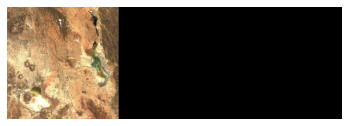

i= 28 loss= 0.11310015205751385 val_loss= 0.20128754079341887 dice_coef= 0.8868993 val_dice_coef= 0.7987125
0.0


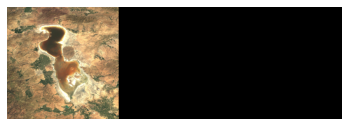

i= 29 loss= 0.08662104313833671 val_loss= 0.18378737270832063 dice_coef= 0.9133788 val_dice_coef= 0.81621265
0.0


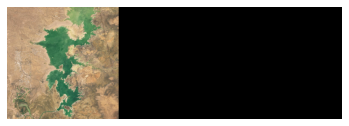

i= 30 loss= 0.09288677520919264 val_loss= 0.16865039467811585 dice_coef= 0.90711296 val_dice_coef= 0.8313497
0.0


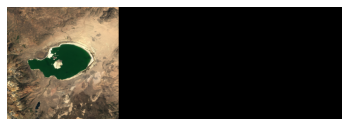

i= 31 loss= 0.09126048339040656 val_loss= 0.12275083363056183 dice_coef= 0.9087394 val_dice_coef= 0.8772491
255.0


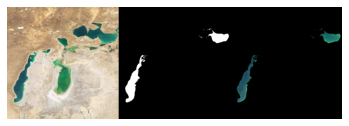

i= 32 loss= 0.09065645974979065 val_loss= 0.1634422093629837 dice_coef= 0.90934354 val_dice_coef= 0.83655775
255.0


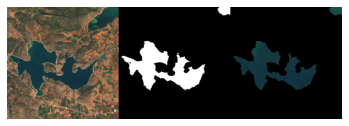

i= 33 loss= 0.08602255269100792 val_loss= 0.10250021815299988 dice_coef= 0.91397727 val_dice_coef= 0.89749974
0.0


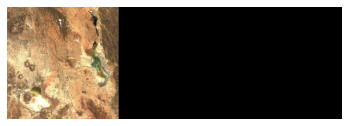

i= 34 loss= 0.09131892940454316 val_loss= 0.09565133154392243 dice_coef= 0.9086812 val_dice_coef= 0.9043487
255.0


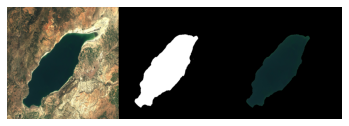

i= 35 loss= 0.09065919654411182 val_loss= 0.13349124193191528 dice_coef= 0.909341 val_dice_coef= 0.8665088
255.0


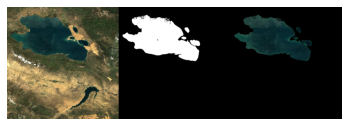

i= 36 loss= 0.09913384830742551 val_loss= 0.13285378217697144 dice_coef= 0.90086627 val_dice_coef= 0.8671462
255.0


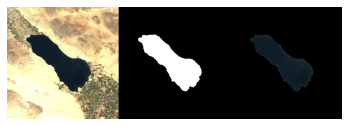

i= 37 loss= 0.08557775020599365 val_loss= 0.172713702917099 dice_coef= 0.9144223 val_dice_coef= 0.82728624
0.0


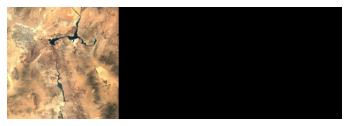

i= 38 loss= 0.10748941668292933 val_loss= 0.17870569229125977 dice_coef= 0.89251053 val_dice_coef= 0.8212943
255.0


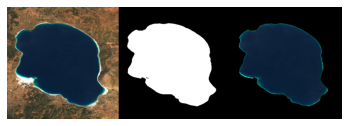


Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
i= 39 loss= 0.08356214217972337 val_loss= 0.22541213035583496 dice_coef= 0.9164379 val_dice_coef= 0.7745878
255.0


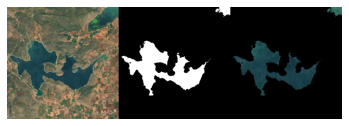

i= 40 loss= 0.0844058354695638 val_loss= 0.196674245595932 dice_coef= 0.91559386 val_dice_coef= 0.80332583
255.0


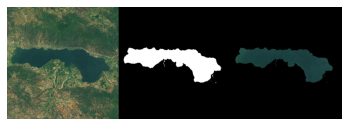

i= 41 loss= 0.07335086182544107 val_loss= 0.22604897022247314 dice_coef= 0.9266492 val_dice_coef= 0.773951
255.0


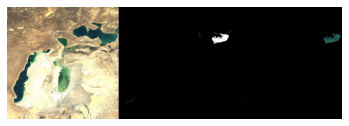

i= 42 loss= 0.07561808008896677 val_loss= 0.19499295353889465 dice_coef= 0.92438203 val_dice_coef= 0.80500716
255.0


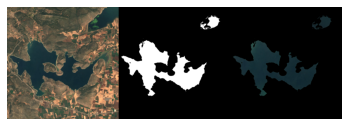

i= 43 loss= 0.0825008139275668 val_loss= 0.1965680241584778 dice_coef= 0.9174989 val_dice_coef= 0.803432
255.0


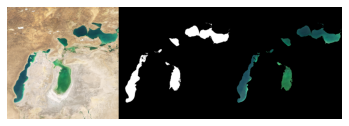

i= 44 loss= 0.08329870847233554 val_loss= 0.23372937738895416 dice_coef= 0.9167015 val_dice_coef= 0.76627064
255.0


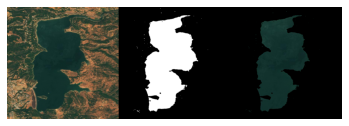

i= 45 loss= 0.0714062117693717 val_loss= 0.21650676429271698 dice_coef= 0.9285937 val_dice_coef= 0.7834932
0.0


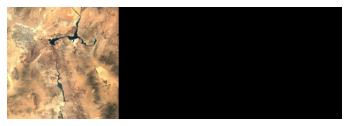

i= 46 loss= 0.09344853183679414 val_loss= 0.2072598308324814 dice_coef= 0.90655154 val_dice_coef= 0.79274017
255.0


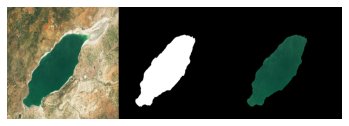

i= 47 loss= 0.08981518536283259 val_loss= 0.22724014520645142 dice_coef= 0.91018474 val_dice_coef= 0.77275985
255.0


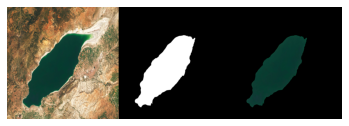


Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.
i= 48 loss= 0.07060802798522146 val_loss= 0.2125993400812149 dice_coef= 0.92939204 val_dice_coef= 0.78740066
255.0


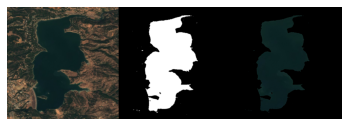

i= 49 loss= 0.06913848697093496 val_loss= 0.26857619285583495 dice_coef= 0.9308614 val_dice_coef= 0.73142374
255.0


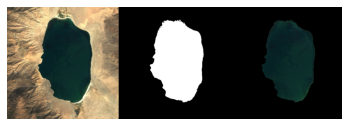

i= 50 loss= 0.07752575832500792 val_loss= 0.2368740975856781 dice_coef= 0.922474 val_dice_coef= 0.763126
0.0


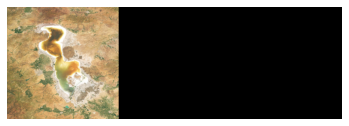

i= 51 loss= 0.06812555120702375 val_loss= 0.2905565857887268 dice_coef= 0.9318746 val_dice_coef= 0.7094434
255.0


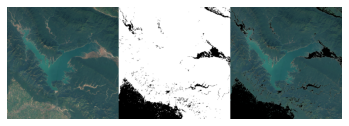

i= 52 loss= 0.07421306434430575 val_loss= 0.2242101401090622 dice_coef= 0.9257866 val_dice_coef= 0.77578986
255.0


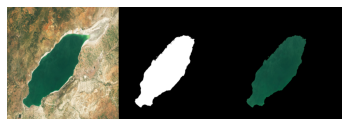

i= 53 loss= 0.05380239863144724 val_loss= 0.3009624034166336 dice_coef= 0.9461978 val_dice_coef= 0.69903755
255.0


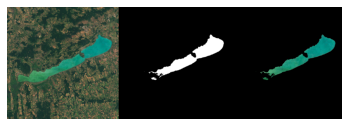

i= 54 loss= 0.06589176654815673 val_loss= 0.2107561230659485 dice_coef= 0.93410826 val_dice_coef= 0.789244
241.1267


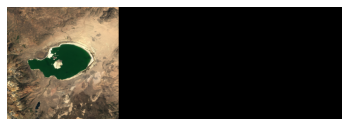

i= 55 loss= 0.06451255522276225 val_loss= 0.25841295123100283 dice_coef= 0.93548757 val_dice_coef= 0.74158704
255.0


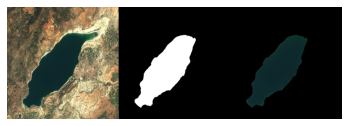

i= 56 loss= 0.07013693378682723 val_loss= 0.21758905053138733 dice_coef= 0.9298631 val_dice_coef= 0.782411
255.0


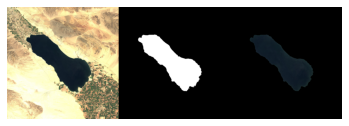


Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
i= 57 loss= 0.07069056180485508 val_loss= 0.2570190131664276 dice_coef= 0.9293097 val_dice_coef= 0.7429811
0.0


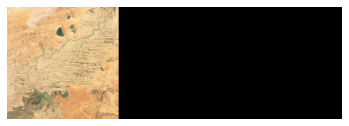

i= 58 loss= 0.0686235551248517 val_loss= 0.1941937565803528 dice_coef= 0.93137634 val_dice_coef= 0.80580616
255.0


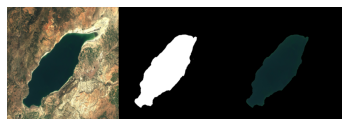

i= 59 loss= 0.05749149343423676 val_loss= 0.25838403403759 dice_coef= 0.9425085 val_dice_coef= 0.74161595
255.0


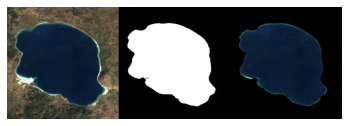

i= 60 loss= 0.059526571892855464 val_loss= 0.20357182025909423 dice_coef= 0.9404735 val_dice_coef= 0.79642814
255.0


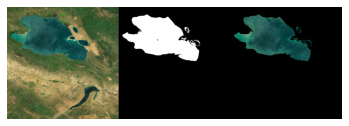

i= 61 loss= 0.06079603580006382 val_loss= 0.2574542135000229 dice_coef= 0.939204 val_dice_coef= 0.7425457
255.0


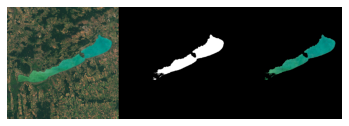

i= 62 loss= 0.053181281006127075 val_loss= 0.21306333541870118 dice_coef= 0.9468186 val_dice_coef= 0.78693664
255.0


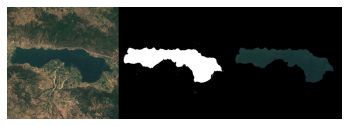

i= 63 loss= 0.05473832226636117 val_loss= 0.25564620196819304 dice_coef= 0.9452613 val_dice_coef= 0.7443538
0.0


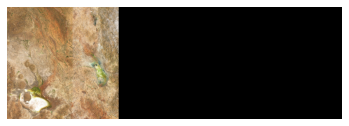

i= 64 loss= 0.060450956068540874 val_loss= 0.19193279445171357 dice_coef= 0.93954927 val_dice_coef= 0.8080672
255.0


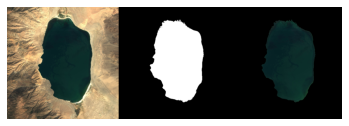

i= 65 loss= 0.06825131805319536 val_loss= 0.26046105325222013 dice_coef= 0.93174833 val_dice_coef= 0.73953897
255.0


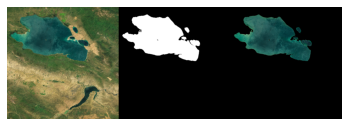


Epoch 00066: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.
i= 66 loss= 0.06754970906073587 val_loss= 0.19853808879852294 dice_coef= 0.9324501 val_dice_coef= 0.8014618
255.0


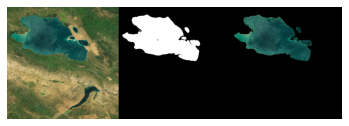

i= 67 loss= 0.05524015071099265 val_loss= 0.2546722859144211 dice_coef= 0.94475913 val_dice_coef= 0.7453277
255.0


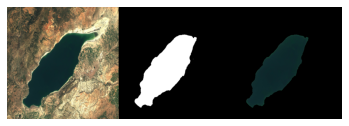

i= 68 loss= 0.052316251344848096 val_loss= 0.22128711342811586 dice_coef= 0.9476837 val_dice_coef= 0.77871287
255.0


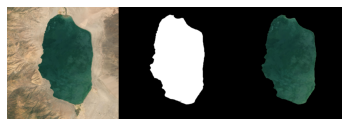

i= 69 loss= 0.059076432596173206 val_loss= 0.32666663229465487 dice_coef= 0.9409231 val_dice_coef= 0.6733334
255.0


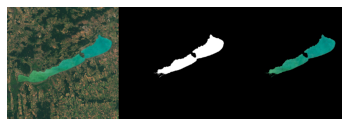

i= 70 loss= 0.061287858820798104 val_loss= 0.2961657017469406 dice_coef= 0.93871224 val_dice_coef= 0.7038342
5.3197145e-05


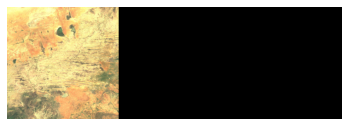

i= 71 loss= 0.05432001833330121 val_loss= 0.3189560443162918 dice_coef= 0.94568 val_dice_coef= 0.681044
255.0


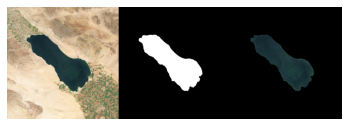

i= 72 loss= 0.05422936824330112 val_loss= 0.2797878861427307 dice_coef= 0.9457704 val_dice_coef= 0.7202121
255.0


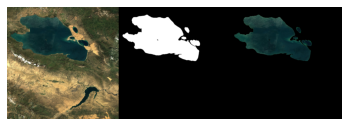

i= 73 loss= 0.047457583745320636 val_loss= 0.3216112345457077 dice_coef= 0.9525426 val_dice_coef= 0.6783888
0.0


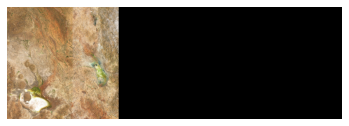

i= 74 loss= 0.062386637821532136 val_loss= 0.3057118564844131 dice_coef= 0.9376135 val_dice_coef= 0.69428813
0.0


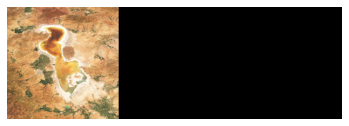


Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.
i= 75 loss= 0.05051137669044629 val_loss= 0.2906773895025253 dice_coef= 0.9494887 val_dice_coef= 0.7093226
255.0


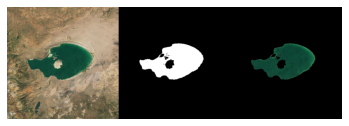

i= 76 loss= 0.05484161523350498 val_loss= 0.2882183104753494 dice_coef= 0.9451584 val_dice_coef= 0.7117817
0.0


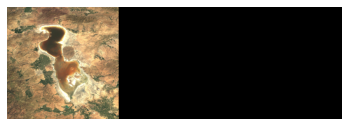

i= 77 loss= 0.051457388986620986 val_loss= 0.27586816549301146 dice_coef= 0.94854254 val_dice_coef= 0.7241319
255.0


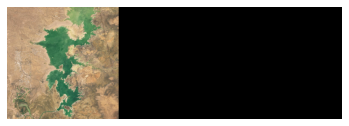

i= 78 loss= 0.04342306183095564 val_loss= 0.26884098947048185 dice_coef= 0.9565769 val_dice_coef= 0.731159
255.0


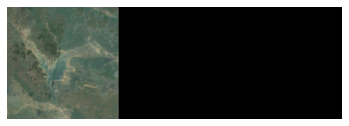

i= 79 loss= 0.050151314651756956 val_loss= 0.2843593150377274 dice_coef= 0.94984883 val_dice_coef= 0.7156407
255.0


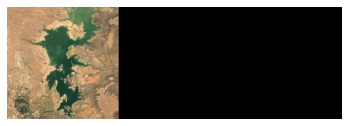

i= 80 loss= 0.04685334552798355 val_loss= 0.22872344851493837 dice_coef= 0.95314664 val_dice_coef= 0.77127653
255.0


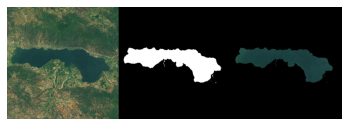

i= 81 loss= 0.0521541904984859 val_loss= 0.26553956270217893 dice_coef= 0.94784576 val_dice_coef= 0.7344604
255.0


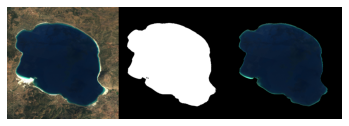

i= 82 loss= 0.05860745865002013 val_loss= 0.22623439729213715 dice_coef= 0.9413924 val_dice_coef= 0.77376556
255.0


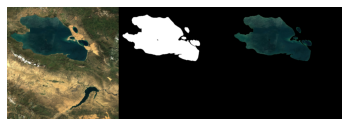

i= 83 loss= 0.04896941164083648 val_loss= 0.26415411233901975 dice_coef= 0.95103055 val_dice_coef= 0.73584586
255.0


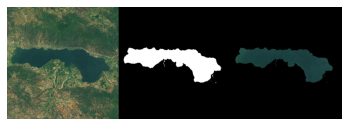


Epoch 00084: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.
i= 84 loss= 0.044337759310739085 val_loss= 0.23372697830200195 dice_coef= 0.955662 val_dice_coef= 0.76627296
255.0


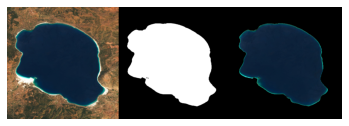

i= 85 loss= 0.05416973641044215 val_loss= 0.2700247883796692 dice_coef= 0.9458305 val_dice_coef= 0.72997516
255.0


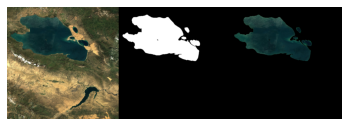

i= 86 loss= 0.053813179543143824 val_loss= 0.23323098421096802 dice_coef= 0.9461869 val_dice_coef= 0.76676905
255.0


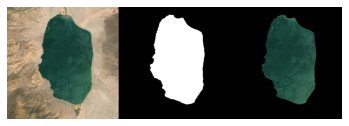

i= 87 loss= 0.04274910855711552 val_loss= 0.26551701724529264 dice_coef= 0.95725065 val_dice_coef= 0.734483
0.0


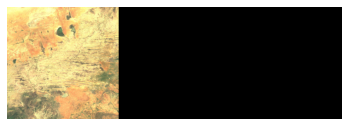

i= 88 loss= 0.0432083761482908 val_loss= 0.23550038933753967 dice_coef= 0.9567918 val_dice_coef= 0.7644996
255.0


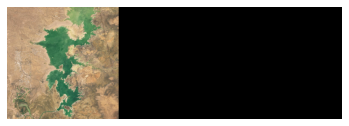

i= 89 loss= 0.04270308226869817 val_loss= 0.22503082752227782 dice_coef= 0.9572973 val_dice_coef= 0.7749692
255.0


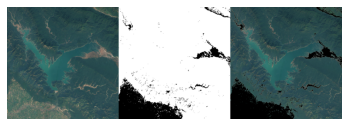

i= 90 loss= 0.041371619492246395 val_loss= 0.1960926502943039 dice_coef= 0.9586289 val_dice_coef= 0.8039073
0.0


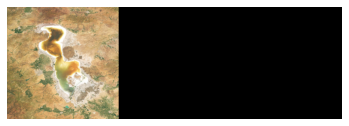

i= 91 loss= 0.044023824783793665 val_loss= 0.1869904488325119 dice_coef= 0.9559763 val_dice_coef= 0.8130096
255.0


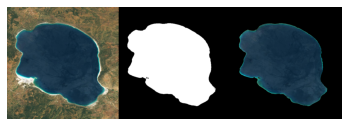

i= 92 loss= 0.05211351775286491 val_loss= 0.1960589736700058 dice_coef= 0.9478867 val_dice_coef= 0.8039411
255.0


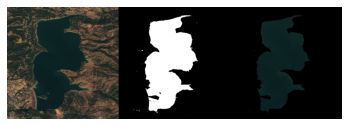


Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.
i= 93 loss= 0.042349943361784284 val_loss= 0.18329556286334991 dice_coef= 0.9576495 val_dice_coef= 0.81670445
255.0


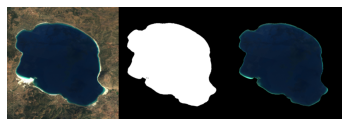

i= 94 loss= 0.04164753775847586 val_loss= 0.19473555088043212 dice_coef= 0.9583524 val_dice_coef= 0.8052645
0.0


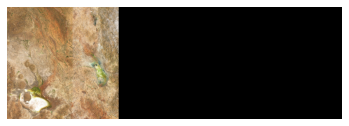

i= 95 loss= 0.03945359870007164 val_loss= 0.2037493497133255 dice_coef= 0.96054655 val_dice_coef= 0.7962507
255.0


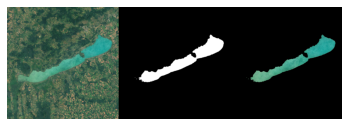

i= 96 loss= 0.0428315003712972 val_loss= 0.23285623788833618 dice_coef= 0.95716864 val_dice_coef= 0.7671438
0.0


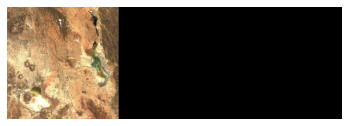

i= 97 loss= 0.04054022504572283 val_loss= 0.22593370974063873 dice_coef= 0.9594597 val_dice_coef= 0.77406627
255.0


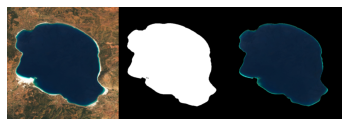

i= 98 loss= 0.04699844393813819 val_loss= 0.23484708964824677 dice_coef= 0.9530013 val_dice_coef= 0.7651528
255.0


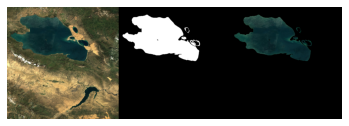

i= 99 loss= 0.053147129636061816 val_loss= 0.22555148005485534 dice_coef= 0.9468525 val_dice_coef= 0.7744485
255.0


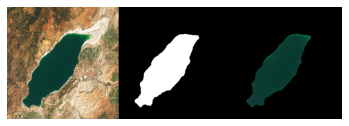

i= 100 loss= 0.05390652857328716 val_loss= 0.23654105365276337 dice_coef= 0.946093 val_dice_coef= 0.76345897
255.0


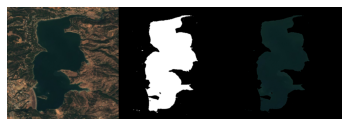

In [21]:
if load_res_dice_mix_history:
  file_id = '116D4NpWzp_lXksXBD7kgL3KD_MFDNBLF'
  destination = 'opt_model_7_res_dice_mix_hist'
  download_file_from_google_drive(file_id, destination)
  with open("opt_model_7_res_dice_mix_hist", "rb") as file_pi:
    res_dice_history = pickle.load(file_pi)
  file_id = '1lH_fSh3AV-vC3W1kCmLGUeXr51ngxvZ_'
  destination = 'opt_model_7_res_dice_mix'
  download_file_from_google_drive(file_id, destination)
  model = tf.keras.models.load_model('opt_model_7_res_dice_mix')
else:
  res_dice_history = model.fit_generator(train_generator,
                                         epochs = 100, 
                                         steps_per_epoch = train_steps,
                                         validation_data = test_generator, 
                                         validation_steps = test_steps,
                                         callbacks = build_callbacks(filepath, 
                                                                     min_delta, 
                                                                     min_lr, 
                                                                     factor), 
                                         verbose = 0,
                                         use_multiprocessing=True)

In [29]:
if not load_res_dice_mix_history:
  #save model and history to load or graph later
  model.save("opt_model_7_res_dice_mix",save_format="h5")
  
  with open('opt_model_7_res_dice_mix_hist', 'wb') as file_pi:
    pickle.dump(res_dice_history.history, file_pi)# save model and history to load or graph later
  
  #del model

In [22]:
def mean_iou(y_true, y_pred):
    yt0 = y_true.squeeze()
    yp0 = tf.keras.backend.cast(y_pred.squeeze() > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# a function for getting a CRF-refined estimated water mask from an input image, 
# and IOU score evaluated against the real mask
def get_pred(x, y):
    #predict the mask 
    pred = model.predict(np.expand_dims(x, 0))
    
    #mask post-processing 
    msk  = pred.squeeze()
    # binarize
    msk[msk >= 0.5] = 1 
    msk[msk < 0.5] = 0
    
    # use CRF to refine mask before it is used as a label
    msk = crf_labelrefine(x.squeeze(), msk).squeeze()
        
    # return the prediction and the IOU score of the prediction
    return msk, mean_iou(y, msk)

In [23]:
all_files = os.listdir('s2cloudless_imagery/data')
shuffle(all_files)

Let's see how this will work:

(-0.5, 511.5, 511.5, -0.5)

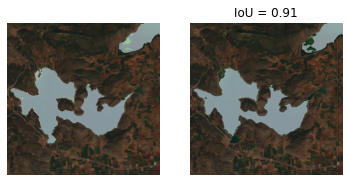

In [32]:
# run the S2 generator function
test_generatorS2  = image_batch_generatorS2(all_files, batch_size = batch_size)

#get a batch of S2 imagery and labels
x, y = next(test_generatorS2) 
#get the predicted mask and iou score for the first
ypred, iou = get_pred(x[0], y[0]) 

#make a plot side-by-side of label ...
plt.subplot(121)
plt.imshow(x[0])
plt.imshow(y[0].squeeze(), alpha=0.5, cmap='gray')
plt.axis('off')

# ... and estimated label
plt.subplot(122)
plt.imshow(x[0])
plt.imshow(ypred.squeeze(), alpha=0.5, cmap='gray')
plt.title('IoU = '+str(iou.numpy())[:4])
plt.axis('off')

For up to 100 images, make a prediction and store the mean iou statistic. Print a validation example every 5th image

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


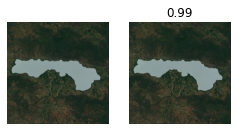

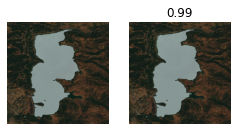

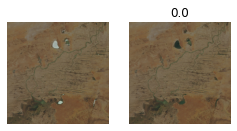

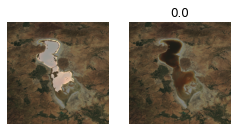

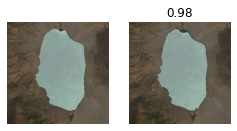

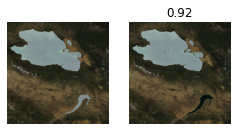

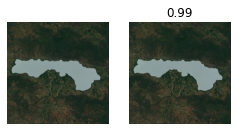

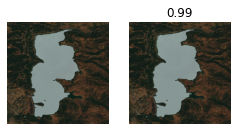

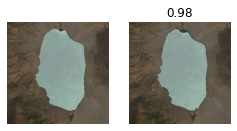

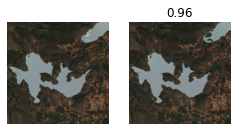

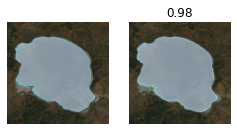

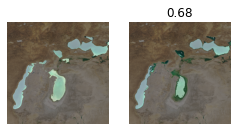

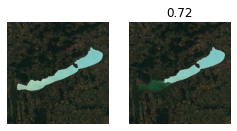

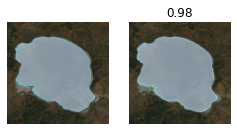

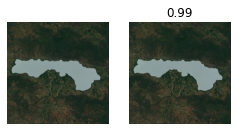

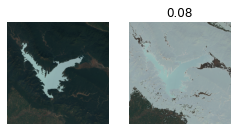

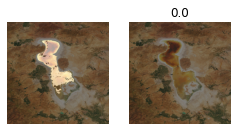

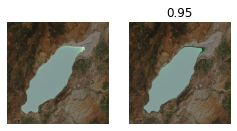

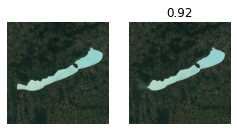

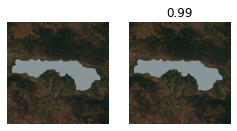

In [33]:
%matplotlib inline
IOU = [] #initialize list
counter = 0 #initialize counter
while counter < 100: # compare 100 images
    x, y = next(test_generatorS2)
    ypred, iou = get_pred(x[0], y[0])
    IOU.append(iou) #update list

    if counter % 5 == 0: #print every 5th comparison
        plt.figure(figsize=(4,6))
        plt.subplot(121)
        plt.imshow(x[0])
        plt.imshow(y[0].squeeze(), alpha=0.5, cmap='gray')
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(x[0])
        plt.imshow(ypred.squeeze(), alpha=0.5, cmap='gray')
        plt.title(str(iou.numpy())[:4])
        plt.axis('off')
        print(counter)  
        
    counter += 1 #update counter

Print the median IOU score to screen and make a histogram plot of the distribution of IOU scores

In [34]:
print(np.median(IOU))

0.9286356


There are 3 peaks in the histogram; the first at IoU ~ 0 where the algorithm didn't detect a lake at all (about 10% of samples), the second around ~0.5 where only one lake out of many were detected, and finally the biggest peak around ~0.95 accoting for about 70% of samples

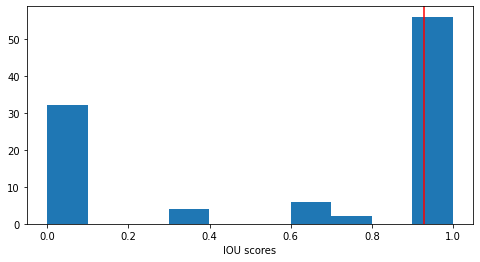

In [35]:
%matplotlib inline
fliers = dict(markerfacecolor='g', marker='p')
plt.figure(figsize=(8,4))
plt.hist(IOU)
plt.xlabel('IOU scores')
plt.axvline(np.median(IOU), color='r')

#### Combine two models in an ensemble prediction

Create two models and use the ```load_weights``` utility to load the weights contained in the h5 files (the product of model training)

In [37]:
file_id = '1BEw63yYh1Wt6Dbz85gm-U1wmi2Nyddbo'
destination = 'opt_model_5_res_dice'
if colab==1:
    download_file_from_google_drive(file_id, destination)
#file_id = '1QgJqz2el-9it4e9rAUUeQgWMpZbcMlKL'
#destination = 'opt_model_6_res_dice2'
#if colab==1:
#    download_file_from_google_drive(file_id, destination)

In [39]:
m1 = tf.keras.models.load_model('opt_model_6_res_dice2',
                               custom_objects = {"dice_coef_loss":dice_coef_loss,
                                                "dice_coef":dice_coef})
#m2 = tf.keras.models.load_model('opt_model_7_res_dice_mix',
#                               custom_objects = {"dice_coef_loss":dice_coef_loss,
#                                                "dice_coef":dice_coef})
#m2 = tf.keras.models.load_model('opt_model_5_res_dice',
#                               custom_objects = {"dice_coef_loss":dice_coef_loss,
#                                                "dice_coef":dice_coef})


In [51]:
if colab==1:
    #!mkdir weights
    m1.save_weights('res_dice_crf_unet1.h5')
    model.save_weights('res_dice_crf_unet2.h5')
    #m2.save_weights('res_dice_unet2.h5')

In [52]:
model1 = res_unet((512, 512, 3), 32)
model1.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef])
model1.load_weights('res_dice_crf_unet1.h5')

model2 = res_unet((512, 512, 3), 32)
model2.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef])
model2.load_weights('res_dice_crf_unet2.h5')

Now update the `get_pred` function to use the maximum of the two model outputs on an input image

In [46]:
# a function for getting a CRF-refined estimated water mask from an input image, 
# and IOU score evaluated against the real mask
def get_pred(x, y, model1, model2):
    #predict the mask 
    pred1 = model1.predict(np.expand_dims(x, 0))
    pred2 = model2.predict(np.expand_dims(x, 0))
    
    #mask post-processing 
    msk  = np.maximum(pred1.squeeze(), pred2.squeeze())
    # binarize
    msk[msk >= 0.5] = 1 
    msk[msk < 0.5] = 0
    
    # use CRF to refine mask before it is used as a label
    msk = crf_labelrefine(x.squeeze(), msk).squeeze()
        
    # return the prediction and the IOU score of the prediction
    return msk, mean_iou(y, msk)

Test things, like you did earlier

(-0.5, 511.5, 511.5, -0.5)

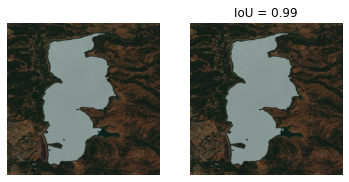

In [47]:
# run the S2 generator function
test_generatorS2  = image_batch_generatorS2(all_files, batch_size = batch_size)

#get a batch of S2 imagery and labels
x, y = next(test_generatorS2) 
#get the predicted mask and iou score for the first
ypred, iou = get_pred(x[0], y[0], model1, model2) 

#make a plot side-by-side of label ...
plt.subplot(121)
plt.imshow(x[0])
plt.imshow(y[0].squeeze(), alpha=0.5, cmap='gray')
plt.axis('off')

# ... and estimated label
plt.subplot(122)
plt.imshow(x[0])
plt.imshow(ypred.squeeze(), alpha=0.5, cmap='gray')
plt.title('IoU = '+str(iou.numpy())[:4])
plt.axis('off')

Just like before, for up to 100 images, make a prediction using both models, and store the mean iou statistic. Print a validation example every 5th image

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


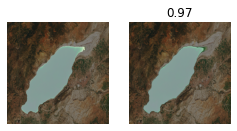

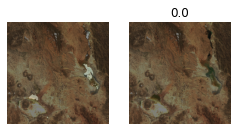

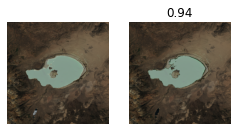

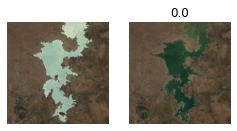

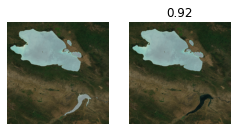

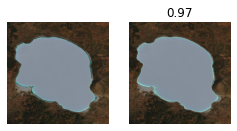

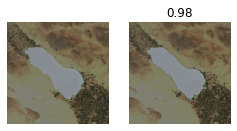

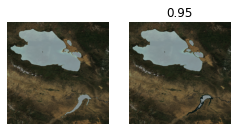

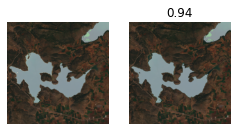

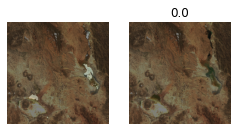

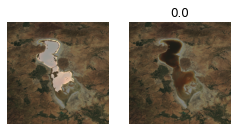

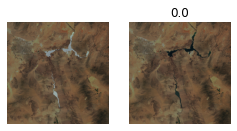

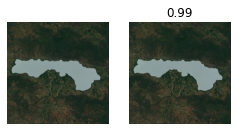

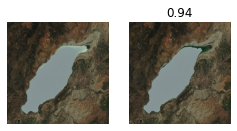

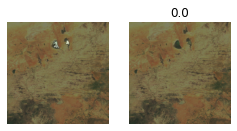

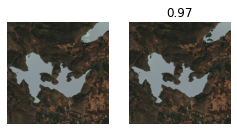

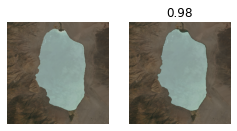

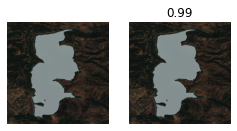

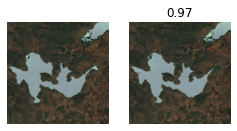

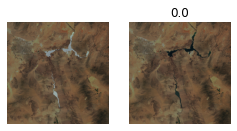

In [48]:
%matplotlib inline
IOU = [] #initialize list
counter = 0 #initialize counter
while counter < 100: # compare 100 images
    x, y = next(test_generatorS2)
    ypred, iou = get_pred(x[0], y[0], model1, model2)
    IOU.append(iou) #update list

    if counter % 5 == 0: #print every 5th comparison
        plt.figure(figsize=(4,6))
        plt.subplot(121)
        plt.imshow(x[0])
        plt.imshow(y[0].squeeze(), alpha=0.5, cmap='gray')
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(x[0])
        plt.imshow(ypred.squeeze(), alpha=0.5, cmap='gray')
        plt.title(str(iou.numpy())[:4])
        plt.axis('off')
        print(counter)  
        
    counter += 1 #update counter

compute the median, and show the histograms of IOUs. As you can see, ensemble predictions are a very simple way to improve predictions

In [49]:
print(np.median(IOU))    

0.9443893


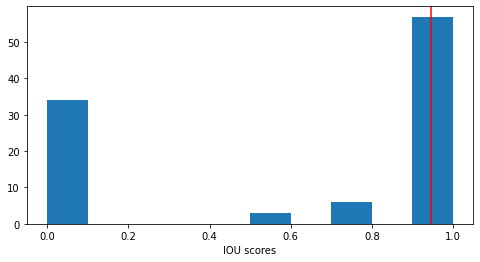

In [50]:
%matplotlib inline
fliers = dict(markerfacecolor='g', marker='p')
plt.figure(figsize=(8,4))
plt.hist(IOU)
plt.xlabel('IOU scores')
plt.axvline(np.median(IOU), color='r')